[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 142, number of negative: 278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12775
[LightGBM] [Info] Number of data points in the train set: 420, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.338095 -> initscore=-0.671794
[LightGBM] [Info] Start training from score -0.671794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

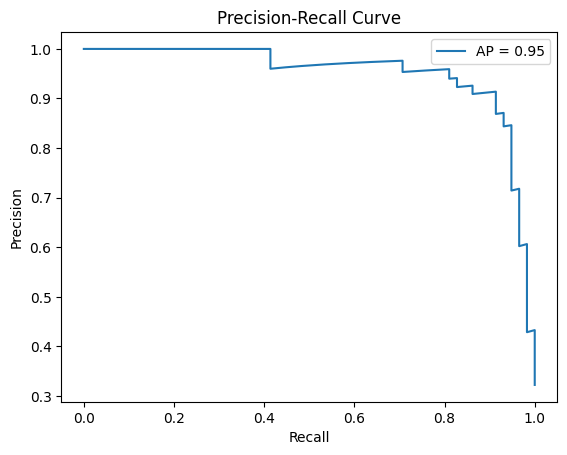

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")
data = pd.read_csv(path+"/data.csv")

# Filtrar los primeros 400 registros con valor 0 y los primeros 200 registros con valor 1
df_0 = data[data["Bankrupt?"] == 0].head(400)
df_1 = data[data["Bankrupt?"] == 1].head(200)

# Concatenar ambos subconjuntos (manteniendo todas las columnas de 'data')
df_subset = pd.concat([df_0, df_1])

# Reiniciar el índice del DataFrame resultante
df_subset = df_subset.reset_index(drop=True)


X = pd.DataFrame(df_subset.drop("Bankrupt?",  axis=1))
y = pd.Series(df_subset["Bankrupt?"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



# Option 2: Class Weighting (Set scale_pos_weight)
# Calculate the ratio for scale_pos_weight
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight = neg_count / pos_count  # LightGBM's recommended weighting



# With Class Weighting (No SMOTE)
model_weighted = lgb.LGBMClassifier(
    random_state=42,
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight  # Critical for imbalance
)
model_weighted.fit(X_train, y_train)

# --- Evaluation ---
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for PR curve

    print(classification_report(y_test, y_pred))
    
    # Precision-Recall Curve (Better than ROC for imbalance)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap_score = average_precision_score(y_test, y_proba)
    
    plt.figure()
    plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()


print("\n=== Weighted LightGBM ===")
evaluate_model(model_weighted, X_test, y_test)

In [4]:
import pickle

# Save the trained model (model_weighted) to a pickle file named 'model.pkl'
with open('model.pkl', 'wb') as file:
    pickle.dump(model_weighted, file)

print("Model saved as model.pkl")


Model saved as model.pkl
